In [4]:
% matplotlib inline
import numpy as np
from numpy import *
from plotBoundary import *
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from cvxopt import matrix, solvers
import pandas as pd
import pdb
from IPython.display import display, HTML
plt.style.use('ggplot')

In [5]:
def kernelized_soft_SVM(X,Y,lmbda,K,max_epochs):
    '''
    return support vector values alpha (n,1) or a function 
    that makes a prediction given a new input
    Gram matrix: the (i, j)th entry K(X[i],X[j]) = phi(X[i]).dot(phi[X[i]])

    '''
    t = 0
    n = X.shape[0]
    alpha = np.zeros(n)
    epoch = 0
    while epoch < max_epochs:

        for i in xrange(n):
            t += 1
            learning_rate = 1./(t*lmbda)
            
            
            if Y[i]*np.dot(alpha,K[i,:]) < 1:
                alpha[i] = (1-learning_rate*lmbda)*alpha[i] + learning_rate*Y[i]
            else:
                alpha[i] = (1-learning_rate*lmbda)*alpha[i] 

        epoch += 1

    return alpha


def linear_ken(x,y):
    output = x.dot(y.T)
    return output

# fig = plt.figure(figsize=(15,3))
# for i in range(5):
#     ax = fig.add_subplot(1,5,i+1)
#     plt.plot(range(5),np.cos(range(5)))
# plt.show()

In [ ]:
# heatmap = plt.pcolor(gaussian_K)
plt.imshow(gaussian_K, cmap='hot', interpolation='nearest')
plt.title(r'$\gamma=3$')
plt.show()

# sns.heatmap(gaussian_K, cmap=plt.cm.Blues, linewidths=.1)

In [34]:
### TODO: Implement train_gaussianSVM ###
# alpha = train_gaussianSVM(X, Y, linear_K, lmbda, epochs);

class P3(object):
    def __init__(self):
        
        self.epochs = 100;
        self.lmbda = 0.02;
        self.gamma_list = [2**i for i in range(2,-3,-1)]
        self.GaussianK = None
        
        self.gamma = None
        self.alpha = None
        self.X = None
        self.C = None
        self.Y = None
        
    def getData(self):
        '''return training, validation, test set of 2D dataset consisting of
        feature matrix X (n,2), labels Y (n,1)'''
        name = '3'
        d = []
        d_name = ['train','validate','test']
        for i in range(3):
            try:
                train = loadtxt('data'+name+'_%s.csv'% d_name[i])
            except:
                continue
            X = train[:, 0:2]
            Y = train[:, 2:3] 
            d.append(X)
            d.append(Y)
         
        X,Y,X_val,Y_val,X_test,Y_test = d

        return X,Y,X_val,Y_val,X_test,Y_test


    def kernelized_soft_SVM(self,X,Y,lmbda,K,max_epochs):
        '''
        return support vector values alpha (n,1) or a function 
        that makes a prediction given a new input
        Gram matrix: the (i, j)th entry K(X[i],X[j]) = phi(X[i]).dot(phi[X[i]])

        '''
        t = 0
        n = X.shape[0]
        alpha = np.zeros(n)
        epoch = 0
        while epoch < max_epochs:

            for i in xrange(n):
                t += 1
                learning_rate = 1./(t*lmbda)


                if Y[i]*np.dot(alpha,K[i,:]) < 1:
                    alpha[i] = (1-learning_rate*lmbda)*alpha[i] + learning_rate*Y[i]
                else:
                    alpha[i] = (1-learning_rate*lmbda)*alpha[i] 

            epoch += 1

        return alpha
    # Define the predict_gaussianSVM(x) function, which uses trained parameters, alpha
    ### TODO:  define predict_gaussianSVM(x) ###

    def GaussRBF_ken(self,x,y):
        output = np.exp(- self.gamma * np.linalg.norm(x-y)**2)
        return output

    def precompute_K(self,X):
        n = X.shape[0]
        gaussian_K = zeros((n,n))
        for i in range(n):
            for j in range(n):
                if kernel=='Gaussian': 
                    gaussian_K[i,j] = self.GaussRBF_ken(X[i],X[j]) 
                elif kernel=='Linear':
                    gaussian_K[i,j] = self.linear_ken(X[i],X[j]) 
        return gaussian_K
    
    def predict_gaussianSVM(self,X_new):
        if kernel=='Gaussian': 
            K_vec = np.array([ self.GaussRBF_ken( X_new , self.X[j]) for j in range(self.X.shape[0])])
        elif kernel=='Linear':
            K_vec = np.array([ self.linear_ken( X_new , self.X[j] ) for j in range(self.X.shape[0])])  
        if np.dot(self.alpha.T,K_vec)> 0:
            y = 1.
        else:
            y = -1.
        return y

    
    def error_rate(self,prediction,target):
        return np.mean(prediction!=target)

    def plot_error(self,X_val,Y_val_pred,Y_val,name): 
        if not np.array_equal(Y_val_pred,Y_val):
            fig = plt.figure(figsize=(15,5))
            plt.title(name)
            i = 1
            errors = np.where(Y_val_pred-Y_val)[0]
            for error_idx in errors:
                ax = fig.add_subplot(np.ceil(len(errors)/3),3,i)
                plt.imshow(X_val[error_idx].reshape((28,-1)))

                i +=1
            plt.show()
    
    def linear_ken(self,x,y):
        return np.dot(x.T,y)
    
    def predictSVM(self,X_new):
        '''
        return a single prediction based on an instance of X
        Gram: precomputed matrix for K(X,X)
        fun: a kernel function
        '''
        w_x = 0.
        
        index = [i for i in range(0,len(self.alpha)) if self.alpha[i]<self.C and self.alpha[i]>1e-5]

        for i in range(0,len(index)):
            if kernel=='Gaussian':
                w_x += self.alpha[index[i],0]*self.Y[index[i],0]*self.GaussRBF_ken(self.X[index[i],:],X_new)  
            elif kernel=='Linear':
                w_x += self.alpha[index[i],0]*self.Y[index[i],0]*self.linear_ken(self.X[index[i],:],X_new)  
        if (w_x)>0:
            y = 1.
        else:
            y = -1.
        return y
    
    def SVM_QP(self,X,Y,C_now,K): 
        m = list(X.shape) 
        
        P = matrix(K)
        q = matrix(-np.ones((m[0],1), dtype=np.float))
        G_temp = np.concatenate((np.eye(len(Y)), -np.eye(len(Y))), axis=0)
        G = matrix(G_temp);
        h_temp = np.concatenate((np.ones((len(Y),1))*C_now, np.zeros((len(Y),1))), axis=0)
        h = matrix(h_temp)
        A = matrix(Y.T)
        b = matrix(0.)
        solution = solvers.qp(P, q, G, h, A, b) 
        alpha = np.array(solution['x'])
        return alpha 
    
    # get predictions, compute error rates and sparsity (num_sv), display errors, 
    
    # decision boundary and the number of support vectors change depending on gamma “
    
    # compare with SVM in previous section (problem 2)
    # Carry out training.

    
    def classify(self):

        num_sv = np.zeros((len(self.gamma_list),2))

        rate_error_validate = np.zeros((len(self.gamma_list),2))
        rate_error_train = np.zeros((len(self.gamma_list),2))
        rate_error_test = np.zeros((len(self.gamma_list),2))

        self.X,self.Y,X_val,Y_val,X_test,Y_test = self.getData()

        print 'Using %s Kernel' % kernel
        for i in range(len(self.gamma_list[:])):
        
            self.gamma = self.gamma_list[i]
            
            # train model by Pegasos 
            self.GaussianK = self.precompute_K(self.X)
            
            self.alpha = self.kernelized_soft_SVM(self.X,self.Y,self.lmbda,self.GaussianK,self.epochs)
        
            num_sv[i,0]= np.sum(self.alpha!=0.)

            Y_val_pred_t = np.array([self.predict_gaussianSVM(self.X[k2]) 
                                   for k2 in range(self.X.shape[0])]).reshape((-1,1))
            Y_val_pred_v = np.array([self.predict_gaussianSVM(X_val[k1]) 
                                   for k1 in range(X_val.shape[0])]).reshape((-1,1))
            Y_val_pred_tt = np.array([self.predict_gaussianSVM(X_test[k2]) 
                                   for k2 in range(X_test.shape[0])]).reshape((-1,1))
            rate_error_train[i,0] = self.error_rate(Y_val_pred_t,self.Y)
            rate_error_validate[i,0] = self.error_rate(Y_val_pred_v,Y_val)
            rate_error_test[i,0] = self.error_rate(Y_val_pred_tt,Y_test)
            
#             plotDecisionBoundary(self.X, self.Y, self.predict_gaussianSVM, [-1,0,1], 
#                                  title = u'Gaussian Kernel SVM by Pegasos with $\gamma=%s$'%self.gamma)
            continue 
    
            plotDecisionBoundary(self.X, self.Y, self.predict_gaussianSVM, [-1,0,1], 
                                 title = u'Pegasos classifier on Training Data')
            plotDecisionBoundary(X_test,Y_test, self.predict_gaussianSVM, [-1,0,1], 
                                     title = u'Pegasos classifier on Test Data')
            plotDecisionBoundary(X_val, Y_val, self.predict_gaussianSVM, [-1,0,1], 
                                     title = u'Pegasos classifier on Validation Data')
            pl.show()
            # train model by QP
            self.C = 1./self.X.shape[0]/self.lmbda
            self.alpha = self.SVM_QP(self.X,self.Y,self.C,self.GaussianK)
            
            print (self.alpha > 0.) * (self.alpha< self.C)
            print np.sum((self.alpha > 0.) * (self.alpha< self.C))
            num_sv[i,1]= np.sum((self.alpha > 0.) * (self.alpha< self.C))
            
            Y_val_pred_t = np.array([self.predictSVM(self.X[k2])
                                   for k2 in range(self.X.shape[0])]).reshape((-1,1))
            Y_val_pred_v = np.array([self.predictSVM(X_val[k2])
                                   for k2 in range(X_val.shape[0])]).reshape((-1,1))
            Y_val_pred_tt = np.array([self.predictSVM(X_test[k2])
                                   for k2 in range(X_test.shape[0])]).reshape((-1,1))
            
            rate_error_train[i,1] = self.error_rate(Y_val_pred_t,self.Y)
            rate_error_validate[i,1] = self.error_rate(Y_val_pred_v,Y_val)
            rate_error_test[i,1] = self.error_rate(Y_val_pred_tt,Y_test)

#             plotDecisionBoundary(self.X, self.Y, self.predictSVM, [-1,0,1], 
#                                  title = u'Gaussian Kernel SVM by QP with $\gamma=%s$'%self.gamma)
            plotDecisionBoundary(self.X, self.Y, self.predictSVM, [-1,0,1], 
                                 title = u'QP classifier on Training Data')
            plotDecisionBoundary(X_test,Y_test, self.predictSVM, [-1,0,1], 
                                     title = u'QP classifier on Test Data')
            plotDecisionBoundary(X_val, Y_val, self.predictSVM, [-1,0,1], 
                                     title = u'QP classifier on Validation Data')
            pl.show()
            
#                 plotDecisionBoundary(X, Y, predict_linearSVM, [-1,0,1], title = 'Linear SVM')
#                 pl.show()
        
            
        return num_sv,rate_error_train,rate_error_validate,rate_error_test
        

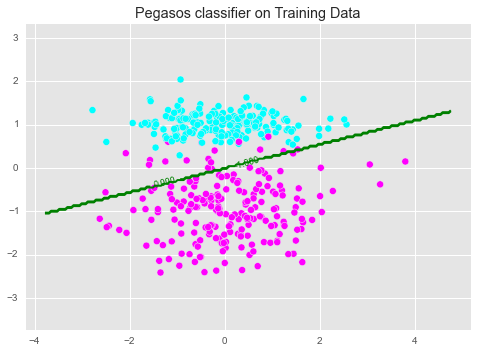

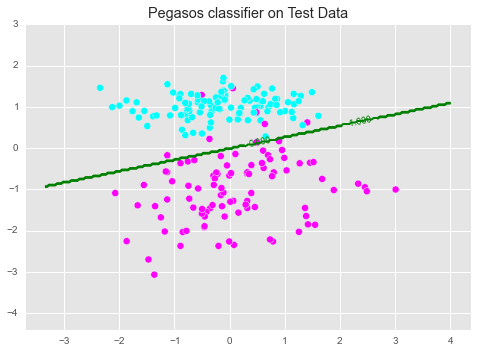

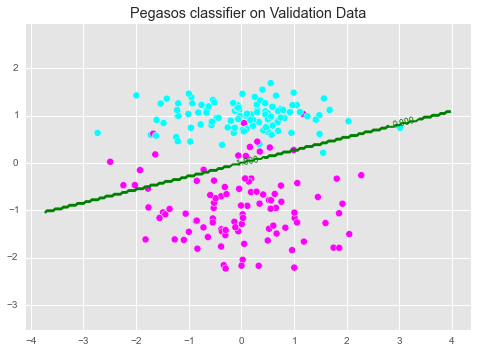

     pcost       dcost       gap    pres   dres
 0: -2.2425e+02 -1.0246e+02  2e+03  2e+01  7e-15
 1: -3.9605e+01 -9.7468e+01  6e+01  2e-15  5e-15
 2: -4.6154e+01 -5.0418e+01  4e+00  4e-16  2e-15
 3: -4.7603e+01 -4.8837e+01  1e+00  1e-15  1e-15
 4: -4.7929e+01 -4.8174e+01  2e-01  8e-16  2e-15
 5: -4.7999e+01 -4.8002e+01  3e-03  4e-16  2e-15
 6: -4.8000e+01 -4.8000e+01  3e-05  2e-16  2e-15
Optimal solution found.


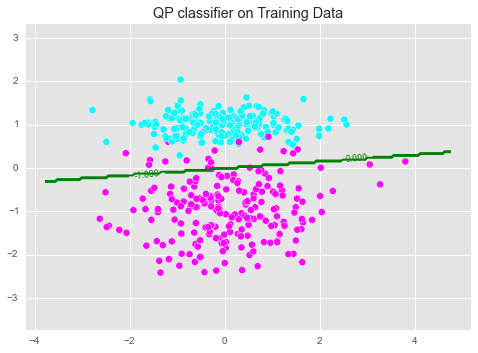

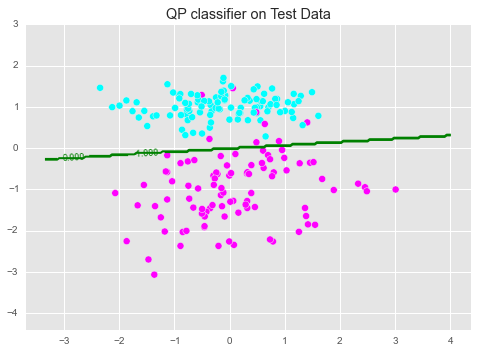

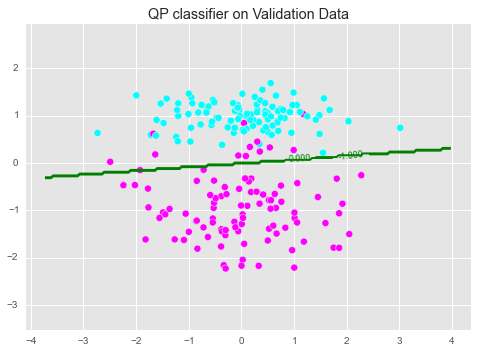

In [22]:
obj = P3()
kernel = 'Linear'
num_sv,rate_error_train,rate_error_validate,rate_error_test = obj.classify() 

[[  26.  400.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]] [[ 0.045   0.0425]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]] [[ 0.085  0.06 ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]] [[ 0.04  0.04]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]]


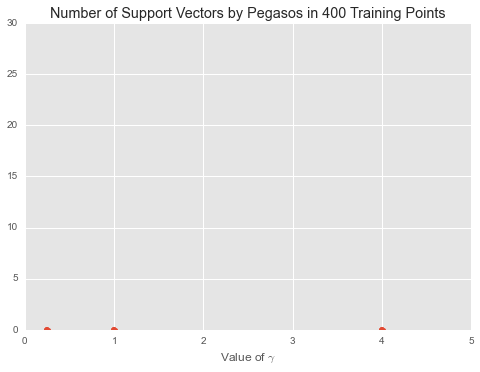

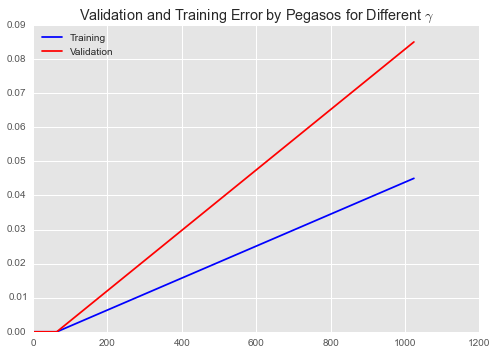

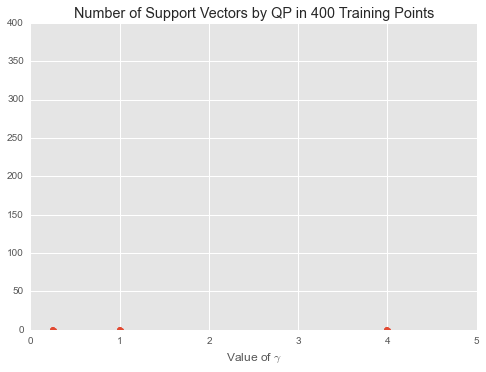

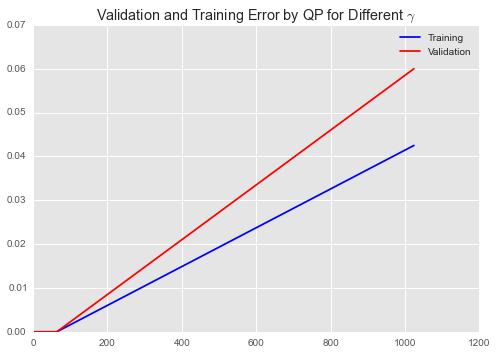

In [23]:
gamma_list = obj.gamma_list
names = ['Pegasos','QP']
print num_sv,rate_error_train,rate_error_validate,rate_error_test
for i in range(2):
    
    plt.plot(gamma_list,num_sv[:,i],'o' )
    plt.title(u'Number of Support Vectors by %s in %s Training Points' % (names[i],obj.X.shape[0]))
    plt.xlim(0,5)
    plt.xlabel(u'Value of $\gamma$')
    plt.show()
    
    plt.plot(gamma_list,rate_error_train[:,i],'blue',label = 'Training')
    plt.plot(gamma_list,rate_error_validate[:,i],'red',label='Validation')
    plt.title(u'Validation and Training Error by %s for Different $\gamma$'% (names[i]))
    plt.legend(loc='best')
    plt.show()

In [24]:
print 'Linear Kernel summary'
dat = np.hstack((rate_error_train,rate_error_validate,rate_error_test,num_sv))
pd.DataFrame(dat)

Linear Kernel summary


0       1      2     3     4     5     6      7
0  0.045  0.0425  0.085  0.06  0.04  0.04  26.0  400.0
1  0.000  0.0000  0.000  0.00  0.00  0.00   0.0    0.0
2  0.000  0.0000  0.000  0.00  0.00  0.00   0.0    0.0
3  0.000  0.0000  0.000  0.00  0.00  0.00   0.0    0.0
4  0.000  0.0000  0.000  0.00  0.00  0.00   0.0    0.0

In [36]:
# Gaussian on P3 data
obj_ = P3()
kernel='Gaussian'
num_sv_,rate_error_train_,rate_error_validate_,rate_error_test_ = obj_.classify() 

Using Gaussian Kernel


In [62]:
num_sv_[:,1] = [244,185,136,124,125]
rate_error_validate_[:,1] = [0.04,0.045,0.05,0.055,0.055]
rate_error_test_[:,1] = '0.0225  0.035   0.0375  0.04    0.0375'.split()
rate_error_train_[:,1] = ' 0.025  0.03   0.035  0.04   0.035'.split()
print kernel,'results',
num_sv_

Gaussian results

array([[  58.,  244.],
       [  38.,  185.],
       [  27.,  136.],
       [  30.,  124.],
       [  30.,  125.]])

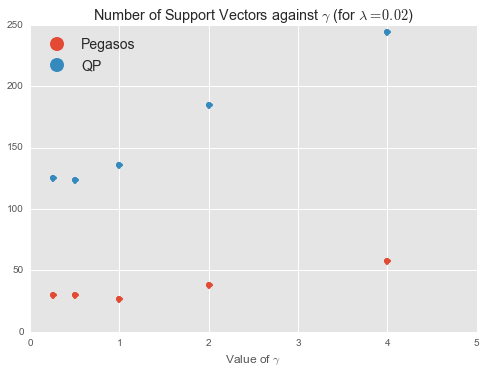

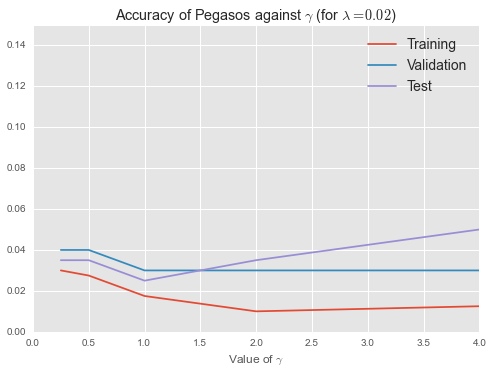

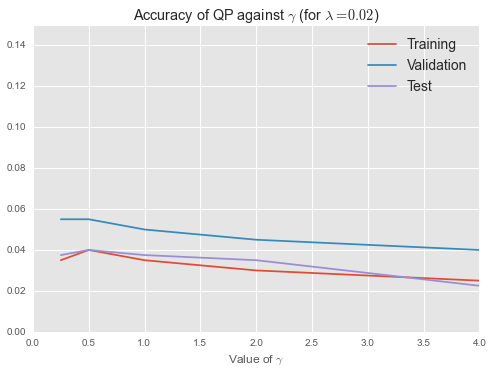

In [61]:
gamma_list = obj_.gamma_list

names = ['Pegasos','QP']

for i in range(2):

    plt.plot(gamma_list,num_sv_[:,i],'o',label = '%s' % names[i])

    plt.title(u'Number of Support Vectors against $\gamma$ (for $\lambda=0.02$)')
    plt.xlim(0,5)
    # plt.ylim(0,1.05)
    plt.xlabel(u'Value of $\gamma$')
    plt.legend(loc='best',markerscale=2,fontsize=14)
plt.show()
    
for i in range(2):
    plt.plot(gamma_list,rate_error_train_[:,i],label = 'Training')
    plt.plot(gamma_list,rate_error_validate_[:,i],label='Validation')
    plt.plot(gamma_list,rate_error_test_[:,i],label='Test')
    plt.title(u'Accuracy of %s against $\gamma$ (for $\lambda=0.02$)' % names[i])
    plt.legend(loc='best',fontsize=14)
    plt.xlabel(u'Value of $\gamma$')
    plt.ylim(0,0.15)
    plt.show()

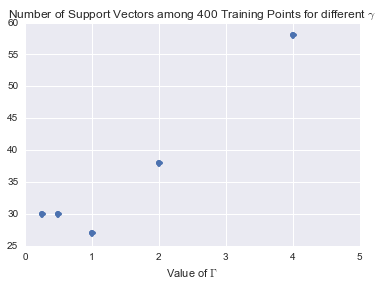

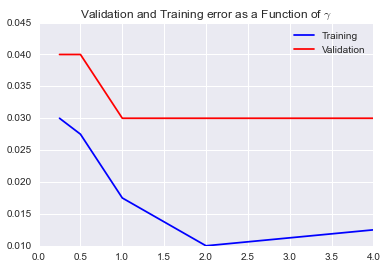

In [73]:
rate_error_train

array([ 1.,  1.,  1.,  1.,  1.])

In [ ]:
X = np.array((4,2),dtype=float)
np.vstack((np.ones((3,2)),X))

In [28]:
class MNIST(object):
    
    
    def __init__(self):
        self.num_samples = [200,300,400,500]
        
        self.epoch_list = [10,1000] 
        self.lmbda_list = [2**i for i in range(1,-11,-3)]
        
        self.gamma = [4,2,0.5,0.25][0]
        self.GaussianK = None
        
    def GaussRBF_ken(self,x,y):
        output = np.exp(- self.gamma * np.linalg.norm(x-y)**2)
        return output
    
    
    
    def getData(self,num_sample,digits,normalize=True):
        '''given set of digits,
        return training, validation, test set of data consisting of
        feature matrix X (num_sample,784)
        labels Y'''
        pos, neg = digits
        
        
        if type(pos) == str:
            pos = (pos,)
            neg = (neg,)
            
        X = np.zeros((len(pos)*num_sample*2,784))
        X_val,X_test = np.zeros((len(pos)*150*2,784)),np.zeros((len(pos)*150*2,784))
                                                              
        # the first half are all positive labels                                                     
        Y, Y_val,Y_test = np.ones((X.shape[0],1)),np.ones((X_val.shape[0],1)),np.ones((X_test.shape[0],1))
        # the second half are all negative labels
        Y[Y.shape[0]/2:] = -1.
        Y_val[Y_val.shape[0]/2:] = -1.
        Y_test[Y_test.shape[0]/2:] = -1.
                                                                                                 
        # fill in the first half of X
        for i in range(len(pos)):
            data = loadtxt('mnist_digit_'+pos[i]+'.csv')
            X[i*num_sample:(i+1)*num_sample] = data[:num_sample,:]
            X_val[i*150:(i+1)*150] = data[num_sample:num_sample+150,:]
            X_test[i*150:(i+1)*150] = data[-150:,:]
            
        # fill in the second half of X
        for i in range(len(neg)):
            
            data = loadtxt('mnist_digit_'+neg[i]+'.csv')
            i += len(neg)
           
            X[i*num_sample:(i+1)*num_sample] = data[:num_sample,:]
            X_val[i*150:(i+1)*150] = data[num_sample:num_sample+150,:]
            X_test[i*150:(i+1)*150] = data[-150:,:]
            
        assert X.shape[1] == 784,'Number of features is not 784!'
        if normalize:    
            return (X*2./255-1., Y, X_val*2./255-1., Y_val, X_test*2./255-1., Y_test)
        else:
            return (X,Y,X_val,Y_val,X_test,Y_test)
         
    def error_rate(self, Y_pred, Y):
        return np.mean(Y_pred!=Y)
        
    def predict_linearSVM(self,X_new,alpha,X,Y):
    
        K_vec = np.array([ np.dot( X_new , X[j] ) for j in range(len(Y))])  
        if np.dot(alpha,K_vec)> 0:
            y = 1.
        else:
            y = -1.
        return y
    
    def predict_gaussianSVM(self,X_new,alpha,X):
    
        K_vec = np.array([ self.GaussRBF_ken( X_new , X[j] ) for j in range(len(X))])  
        if np.dot(alpha,K_vec)> 0:
            y = 1.
        else:
            y = -1.
        return y  
    
    def precompute_K(self,X):
        n = X.shape[0]
        gaussian_K = zeros((n,n))
        for i in range(n):
            for j in range(n):
                gaussian_K[i,j] = self.GaussRBF_ken(X[i],X[j]) 
        return gaussian_K
    
    def SVM_QP(self,X,Y,C_now,K): 

        m = list(X.shape) 
        
        P = matrix(K)
        q = matrix(-np.ones((m[0],1), dtype=np.float))
        G_temp = np.concatenate((np.eye(len(Y)), -np.eye(len(Y))), axis=0)
        G = matrix(G_temp);
        h_temp = np.concatenate((np.ones((len(Y),1))*C_now, np.zeros((len(Y),1))), axis=0)
        h = matrix(h_temp)
        A = matrix(Y.T)
        b = matrix(0.)
        solution = solvers.qp(P, q, G, h, A, b) 
        alpha = np.array(solution['x'])
        return alpha

    def predictSVM(self,X_new,X,Y,C_now,f,alpha):
        '''
        return a single prediction based on an instance of X
        Gram: precomputed matrix for K(X,X)
        fun: a kernel function
        '''
        w_x = 0.
        
        index = [i for i in range(0,len(alpha)) if alpha[i]<C_now and alpha[i]>1e-5]

        for i in range(0,len(index)):
            w_x += alpha[index[i],0]*Y[index[i],0]*f(X[index[i],:],X_new)  
        if (w_x)>0:
            y = 1.
        else:
            y = -1.
        return y
    
    def kernelized_soft_SVM(self,X,Y,K,lmbda,max_epochs,eps=1e-4):
        '''
        return support vector values alpha (n,1) or a function 
        that makes a prediction given a new input
        Gram matrix: the (i, j)th entry K(X[i],X[j]) = phi(X[i]).dot(phi[X[i]])

        '''
        t = 0
        n = X.shape[0]
        alpha = np.zeros(n)
        old_alpha = np.ones(n)*10
        
        epoch = 0
        
        while epoch < max_epochs:

            for i in xrange(n):
                t += 1
                learning_rate = 1./(t*lmbda)
                
                assert alpha.shape==(n,)
                assert K.shape==(n,n)
                
                if Y[i]*np.dot(alpha,K[i,:]) < 1:
                    alpha[i] = (1-learning_rate*lmbda)*alpha[i] + learning_rate*Y[i]
                else:
                    alpha[i] = (1-learning_rate*lmbda)*alpha[i] 
            
            if np.linalg.norm(alpha-old_alpha)<eps:
                break
                
            old_alpha = np.copy(alpha)
            epoch += 1

        return alpha,epoch
    
    def plot_error(self,X_val,Y_val_pred,Y_val,name): 
        
        # there is any error, plot them
        if not np.array_equal(Y_val_pred,Y_val):
            errors = np.where(Y_val_pred-Y_val)[0]
            fig = plt.figure(figsize=(10,len(errors)))
            plt.title(name)
            i = 1
            for error_idx in errors:
                ax = fig.add_subplot(1,3,i)
                plt.imshow(X_val[error_idx].reshape((28,-1)))
                i +=1
            plt.show()

    def classify(self,digits,epoch,normalize=True):
        '''given features X and labels Y, train a Pegasos SVM classifier for a given digit so that,
        given X_new, predict it is the same digit'''
        # get data 
        run_time = np.zeros((len(self.num_samples),2))
        accuracy = np.zeros((len(self.num_samples),2))
        
        # compare method: Pegasos vs QP by accuracy and running time as num_samples increases
            
        # compare both as epochs and lambda of Pegasos vary using tuned gamma =0.02
        
        for i in range(len(self.num_samples[:])):
            num_sample = self.num_samples[i]
            print 
            print 'Classifying with ',num_sample,' samples'
            X,Y,X_val,Y_val,X_test,Y_test = self.getData(num_sample,digits)

            # train soft SVM by Pegasos and get predictions
            start = time.time()
            lmbda = self.lmbda_list[0]
            
            self.GaussianK = self.precompute_K(X)

            alpha,iterations = self.kernelized_soft_SVM(X,Y,self.GaussianK,lmbda,epoch)
            print 'Training Peg took ', iterations,' iterations!'
            Y_val_pred_p = np.array([self.predict_gaussianSVM(X_val[k1],alpha,X) 
                                   for k1 in range(X_val.shape[0])]).reshape((-1,1))
            
           
            
            accuracy[i,0] = self.error_rate(Y_val_pred_p,Y_val)
            run_time[i,0] = time.time()-start
            
            # train soft SVM by QP and get predictions
            start = time.time()
            C = 1./X.shape[0]/lmbda
            alpha = self.SVM_QP(X,Y,C,self.GaussianK)
            
            Y_val_pred_q = np.array([self.predictSVM(X_val[k2],X,Y,C,self.GaussRBF_ken,alpha)
                                   for k2 in range(X_val.shape[0])]).reshape((-1,1))
            
            accuracy[i,1] = self.error_rate(Y_val_pred_q,Y_val)
            run_time[i,1] = time.time()-start
        
#         self.plot_error(X_val,Y_val_pred_p,Y_val,'Peg with %s training samples' % num_sample)
#         self.plot_error(X_val,Y_val_pred_q,Y_val,'QP with %s training samples' % num_sample)
        
    
        tbl = pd.DataFrame( np.hstack( (accuracy,run_time )),
                            index = self.num_samples,columns = ['Peg','QP']*2)
        tbl.to_csv('Running time Peg vs QP.csv')
        return tbl
        
    def validation(self,num_sample,digits):
        ''' compare QP and pegasos as lambda and epochs vary for Pegasos'''
        X,Y,X_val,Y_val,X_test,Y_test = self.getData(num_sample,digits,normalize=False)
        
    
        alpha_p = []
        iterations_list = []
        alpha_q = []
        C_list = [100,1,0.01]
        gamma_list = [4,1,0.25]
#         param_error = np.zeros((len(self.lmbda_list),2))

        
        param_error = np.ones((3,3))
        for i,C in enumerate(C_list):
            for j, gamma in enumerate(gamma_list):
                 
            # train model by Pegasos 
                self.gamma = gamma
                
#                 print C, gamma
                self.GaussianK = self.precompute_K(X)
                lmbda = 1./X.shape[0]/C
                
                alpha,iterations = self.kernelized_soft_SVM(X,Y,self.GaussianK,lmbda,100)
    #             alpha_p.append(alpha)
    #             iterations_list.append(iterations)

                Y_val_pred_p = np.array([self.predict_gaussianSVM(X_val[k1],alpha,X) 
                                       for k1 in range(X_val.shape[0])]).reshape((-1,1))

                param_error[i,j] = self.error_rate(Y_val_pred_p,Y_val)

                # train soft SVM by QP and get predictions
    #             C = 1./X.shape[0]/lmbda

#                 alpha = self.SVM_QP(X,Y,C,self.GaussianK)
#                 alpha_q.append(alpha)

#                 Y_val_pred_q = np.array([self.predictSVM(X_val[k2],X,Y,C,self.GaussRBF_ken,alpha)
#                                        for k2 in range(X_val.shape[0])]).reshape((-1,1))

#                 param_error[i,j] = self.error_rate(Y_val_pred_q,Y_val)
   

    #         peg = np.argmin(param_error[:,0])
#             qp = np.argmin(param_error[:,1])
        
        
        
        opt_idx = np.where(param_error == np.amin(param_error))
        print opt_idx
        print param_error
        if len(opt_idx[0]) >1:
            C_now,gamma_now = C_list[opt_idx[0][0]],gamma_list[opt_idx[1][0]]
        else:
            C_now,gamma_now = C_list[opt_idx[0]],gamma_list[opt_idx[1]]
        print 'check validation parameters:', C_now,gamma_now
        
#         print opt_idx
         
        lmbda = 1./X.shape[0]/C_now
        
        self.gamma = gamma_now
        self.GaussianK = self.precompute_K(X)
        
        alpha,iterations = self.kernelized_soft_SVM(X,Y,self.GaussianK,lmbda,100)
        Y_test_pred_p = np.array([self.predict_gaussianSVM(X_test[k3],alpha,X) 
                                   for k3 in range(X_test.shape[0])]).reshape((-1,1))
        error_p = self.error_rate(Y_test_pred_p,Y_test) 
        numofsv = np.sum(alpha.reshape((-1,))!=0.)        
        
#         alpha = SVM(X,Y,C_now) 
#         numofsv = len([i for i in range(0,len(alpha)) if alpha[i]<C_now and alpha[i]>1e-5])

#         test_error = error_rate(X_test,Y_test)
        print (numofsv)
        return error_p,numofsv
        
#         print 'Validation error as a function of lambda with %s samples: '% num_sample
#         display(pd.DataFrame(param_error.T,index = ['Peg','QP'],columns=C_list))


#         # test Peg
#         Y_test_pred_p = np.array([self.predict_gaussianSVM(X_test[k3],alpha_p[peg],X) 
#                                    for k3 in range(X_test.shape[0])]).reshape((-1,1))
#         error_p = self.error_rate(Y_test_pred_p,Y_test) 
#         self.plot_error(X_test,Y_test_pred_p,Y_test,'Peg')


#         print 'Among these iterations: '
#         print iterations_list
#         print 'Peg took ',iterations_list[peg],'iterations for the best lambda ',self.lmbda_list[peg]


        # test QP
#         C = 1./X.shape[0]/self.lmbda_list[peg]
#         C = C_list[qp]
    
#         Y_test_pred_q = np.array([self.predictSVM(X_test[k4],X,Y,C,self.GaussRBF_ken,alpha_q[qp])
#                                for k4 in range(X_test.shape[0])]).reshape((-1,1))
#         error_q = self.error_rate(Y_test_pred_q,Y_test)
# #         self.plot_error(X_test,Y_test_pred_q,Y_test,'QP')
#         return error_q
#         return error_p,error_q,np.mean(alpha_p[peg] != 0.),np.mean(alpha_q[qp] != 0.)
tasks = [map(str,item) for item in [(1,7),(3,5),(4,9)]]
x,y = ((0,2,4,6,8),(1,3,5,7,9))
tasks.append((map(str,x),map(str,y)))
for task in tasks: 
    print 'Classifying %s vs %s '% (task[0],task[1])
    print MNIST().validation(200,task)      
    

Classifying 1 vs 7 
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))
[[ 0.42666667  0.42666667  0.42666667]
 [ 0.42666667  0.42666667  0.42666667]
 [ 0.42666667  0.42666667  0.42666667]]
check validation parameters: 100 4
371
(0.40333333333333332, 371)
Classifying 3 vs 5 
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))
[[ 0.41666667  0.41666667  0.41666667]
 [ 0.41666667  0.41666667  0.41666667]
 [ 0.41666667  0.41666667  0.41666667]]
check validation parameters: 100 4
366
(0.41999999999999998, 366)
Classifying 4 vs 9 
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))
[[ 0.40666667  0.40666667  0.40666667]
 [ 0.40666667  0.40666667  0.40666667]
 [ 0.40666667  0.40666667  0.40666667]]
check validation parameters: 100 4
365
(0.39000000000000001, 365)
Classifying ['0', '2', '4', '6', '8'] vs ['1', '3', '5', '7', '9'] 
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))
[[ 0.41  0.41  0.41]
 [ 0.41

In [ ]:


plt.hexbin(x,y)

plt.show()

Classifying 1 vs 7 

Classifying with  200  samples
Training Peg took  243  iterations!


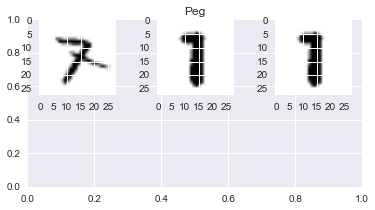

     pcost       dcost       gap    pres   dres
 0: -1.0587e+02 -2.3483e+01  1e+03  4e+01  2e-16
 1: -1.9642e+01 -1.6186e+00  8e+01  2e+00  3e-16
 2: -5.3233e-01 -9.5969e-01  1e+00  1e-02  5e-16
 3: -4.6489e-01 -5.5895e-01  9e-02  4e-16  3e-16
 4: -4.9893e-01 -5.0029e-01  1e-03  2e-15  2e-16
 5: -4.9963e-01 -4.9965e-01  1e-05  2e-15  3e-16
 6: -4.9964e-01 -4.9964e-01  1e-07  1e-15  1e-16
Optimal solution found.


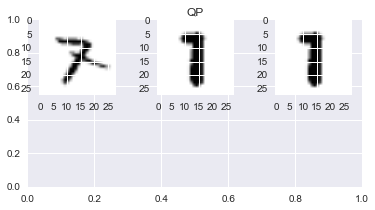


Classifying with  300  samples
Training Peg took  200  iterations!


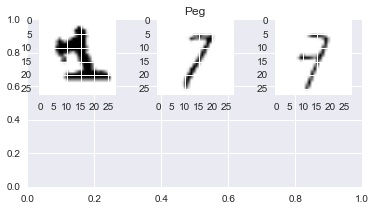

     pcost       dcost       gap    pres   dres
 0: -1.5419e+02 -3.5147e+01  2e+03  5e+01  8e-17
 1: -3.0194e+01 -2.1178e+00  1e+02  3e+00  6e-16
 2: -6.2219e-01 -9.6415e-01  1e+00  2e-02  9e-16
 3: -4.5769e-01 -6.3333e-01  2e-01  1e-15  3e-16
 4: -4.9723e-01 -5.0115e-01  4e-03  9e-16  2e-16
 5: -4.9972e-01 -4.9976e-01  4e-05  5e-16  4e-16
 6: -4.9974e-01 -4.9974e-01  4e-07  1e-15  3e-16
Optimal solution found.


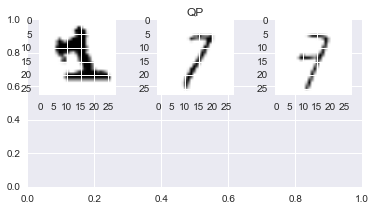


Classifying with  400  samples
Training Peg took  174  iterations!


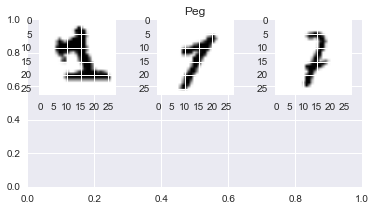

     pcost       dcost       gap    pres   dres
 0: -1.9973e+02 -4.6864e+01  3e+03  5e+01  3e-16
 1: -4.1446e+01 -2.8046e+00  2e+02  4e+00  3e-16
 2: -7.2901e-01 -9.6834e-01  2e+00  3e-02  1e-15
 3: -4.4544e-01 -7.1300e-01  3e-01  4e-15  6e-16
 4: -4.9338e-01 -5.0265e-01  9e-03  3e-15  2e-16
 5: -4.9973e-01 -4.9982e-01  9e-05  2e-15  2e-16
 6: -4.9979e-01 -4.9979e-01  9e-07  9e-16  2e-16
 7: -4.9979e-01 -4.9979e-01  9e-09  2e-15  3e-16
Optimal solution found.


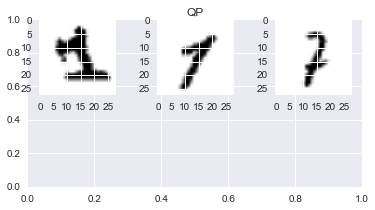


Classifying with  500  samples
Training Peg took  156  iterations!


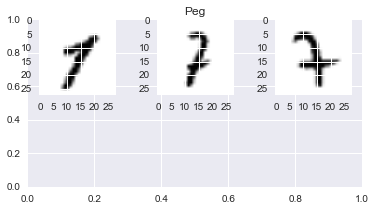

     pcost       dcost       gap    pres   dres
 0: -2.4223e+02 -5.8698e+01  3e+03  6e+01  2e-16
 1: -5.2970e+01 -3.6386e+00  2e+02  4e+00  3e-16
 2: -8.4755e-01 -9.7091e-01  3e+00  4e-02  8e-16
 3: -4.4345e-01 -7.5807e-01  3e-01  6e-15  5e-16
 4: -4.9138e-01 -5.0330e-01  1e-02  6e-15  2e-16
 5: -4.9974e-01 -4.9986e-01  1e-04  8e-16  1e-16
 6: -4.9982e-01 -4.9982e-01  1e-06  4e-15  4e-16
 7: -4.9982e-01 -4.9982e-01  1e-08  1e-15  2e-16
Optimal solution found.


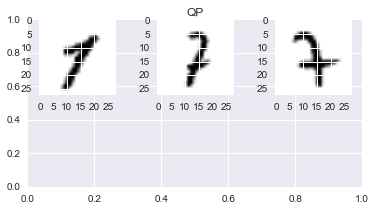

Peg    QP        Peg        QP
200  0.01  0.01   4.364175  2.032622
300  0.01  0.01   7.095394  2.911000
400  0.01  0.01  11.942295  4.062878
500  0.01  0.01  15.670542  5.339055

Classifying 3 vs 5 

Classifying with  200  samples
Training Peg took  243  iterations!


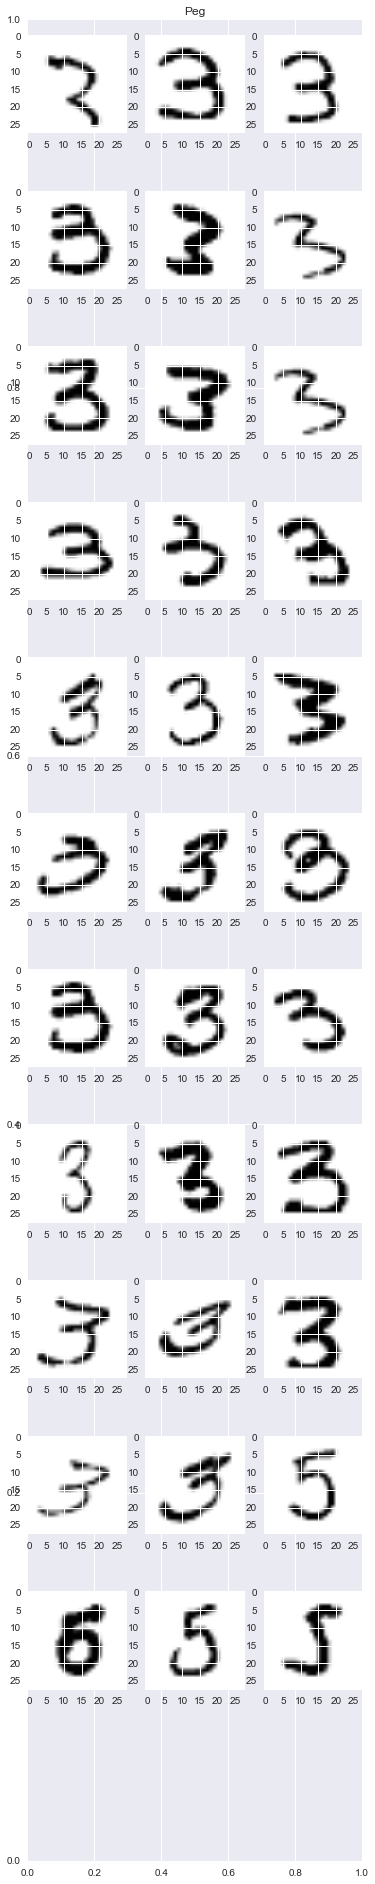

     pcost       dcost       gap    pres   dres
 0: -1.0492e+02 -2.3534e+01  1e+03  4e+01  1e-16
 1: -1.9832e+01 -1.6631e+00  8e+01  2e+00  5e-16
 2: -5.3216e-01 -9.5965e-01  1e+00  1e-02  8e-16
 3: -4.6500e-01 -5.5859e-01  9e-02  5e-16  4e-16
 4: -4.9892e-01 -5.0028e-01  1e-03  4e-16  2e-16
 5: -4.9962e-01 -4.9964e-01  1e-05  1e-15  8e-17
 6: -4.9963e-01 -4.9963e-01  1e-07  4e-16  3e-16
Optimal solution found.


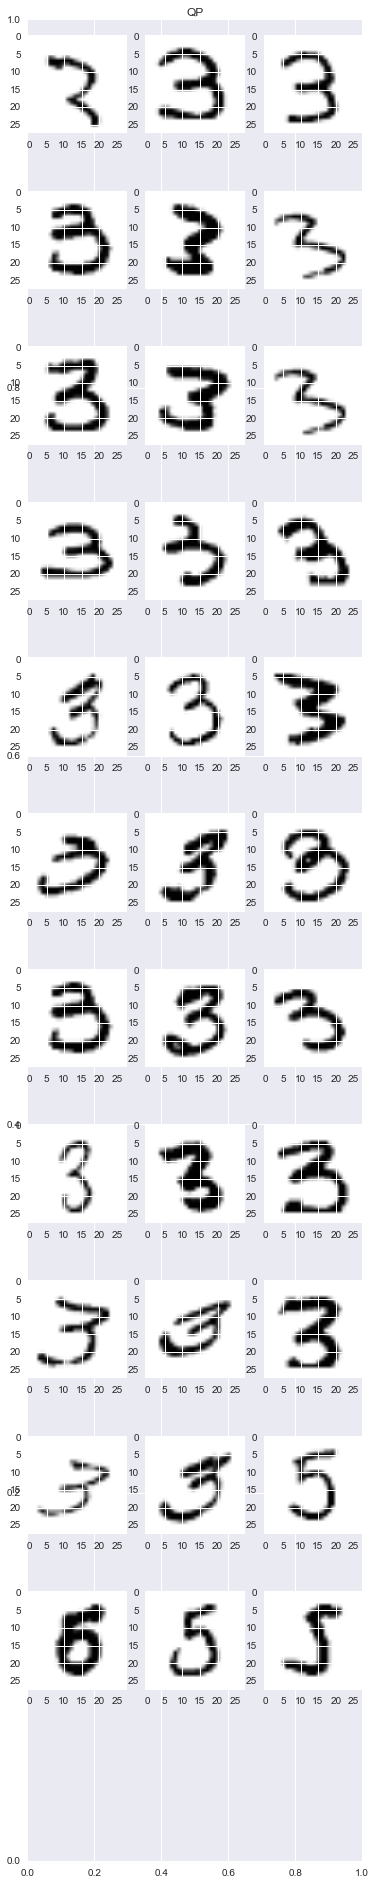


Classifying with  300  samples
Training Peg took  200  iterations!


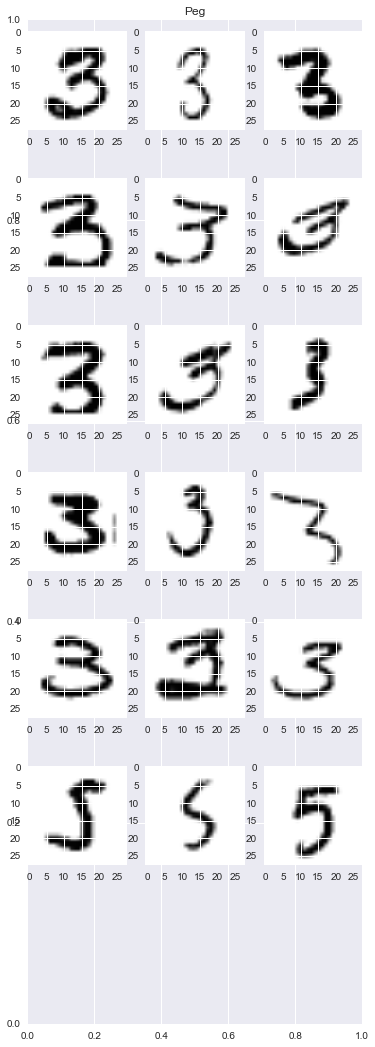

     pcost       dcost       gap    pres   dres
 0: -1.5208e+02 -3.5196e+01  2e+03  5e+01  1e-16
 1: -3.0557e+01 -2.2432e+00  1e+02  3e+00  3e-16
 2: -6.2246e-01 -9.6494e-01  1e+00  2e-02  8e-16
 3: -4.5761e-01 -6.3380e-01  2e-01  1e-15  4e-16
 4: -4.9721e-01 -5.0114e-01  4e-03  2e-15  2e-16
 5: -4.9971e-01 -4.9975e-01  4e-05  1e-15  1e-16
 6: -4.9973e-01 -4.9973e-01  4e-07  1e-15  2e-16
Optimal solution found.


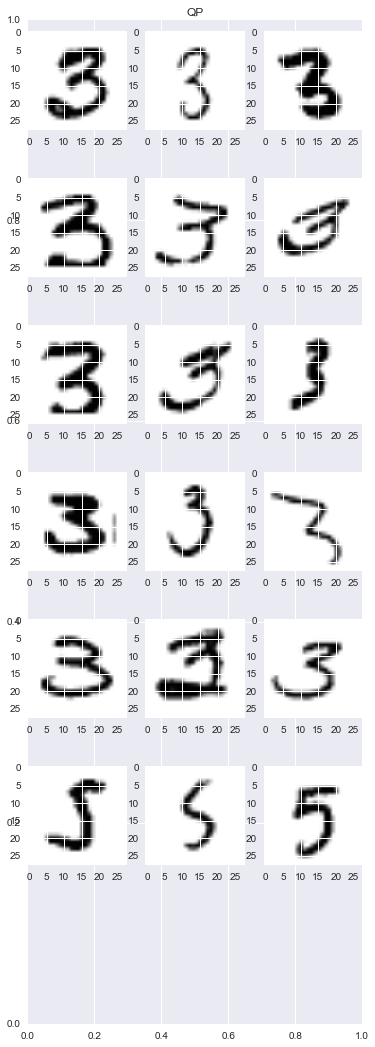


Classifying with  400  samples
Training Peg took  174  iterations!


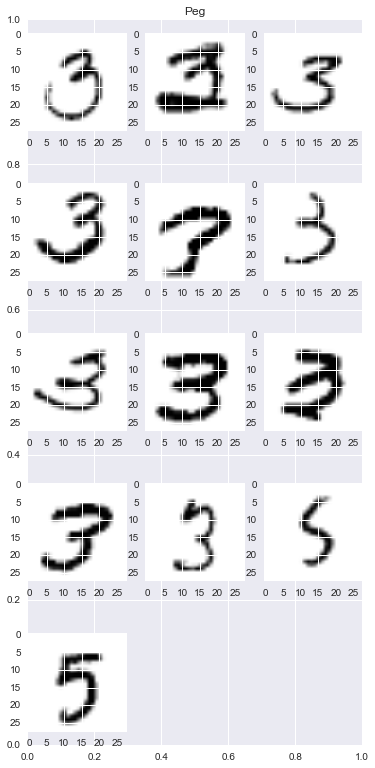

     pcost       dcost       gap    pres   dres
 0: -1.9486e+02 -4.7035e+01  3e+03  5e+01  2e-16
 1: -4.2207e+01 -3.0662e+00  2e+02  4e+00  2e-16
 2: -7.3360e-01 -9.6965e-01  2e+00  3e-02  9e-16
 3: -4.4591e-01 -7.1426e-01  3e-01  8e-16  5e-16
 4: -4.9338e-01 -5.0269e-01  9e-03  6e-17  2e-16
 5: -4.9971e-01 -4.9981e-01  9e-05  2e-16  3e-16
 6: -4.9978e-01 -4.9978e-01  9e-07  4e-17  1e-16
 7: -4.9978e-01 -4.9978e-01  9e-09  1e-15  3e-16
Optimal solution found.


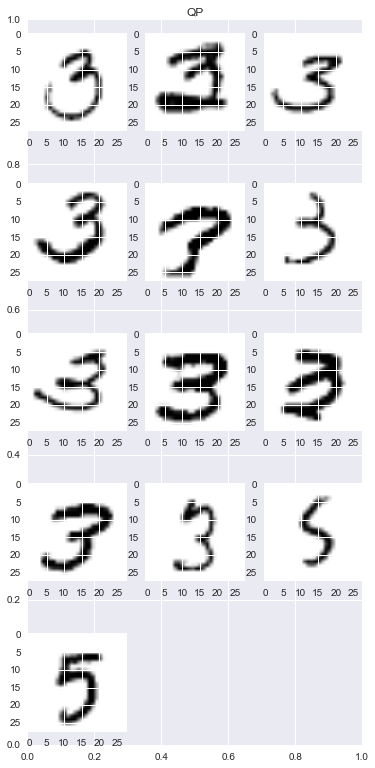


Classifying with  500  samples
Training Peg took  156  iterations!


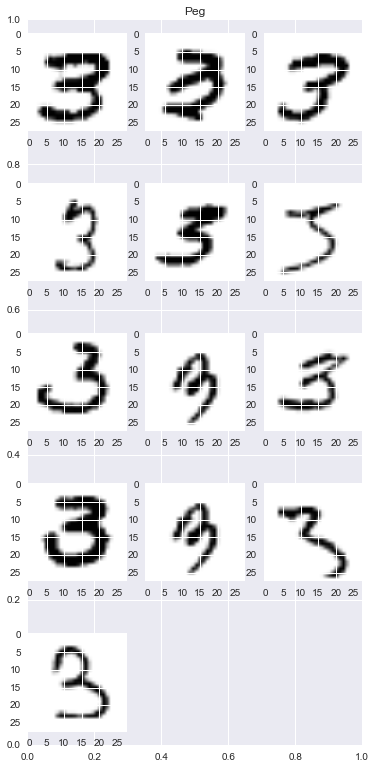

     pcost       dcost       gap    pres   dres
 0: -2.3365e+02 -5.9073e+01  3e+03  6e+01  8e-17
 1: -5.4392e+01 -4.0774e+00  2e+02  4e+00  3e-16
 2: -8.5830e-01 -9.7410e-01  3e+00  4e-02  6e-16
 3: -4.4384e-01 -7.6184e-01  3e-01  3e-15  3e-16
 4: -4.9125e-01 -5.0355e-01  1e-02  4e-15  3e-16
 5: -4.9972e-01 -4.9984e-01  1e-04  3e-15  2e-16
 6: -4.9981e-01 -4.9981e-01  1e-06  2e-15  4e-16
 7: -4.9981e-01 -4.9981e-01  1e-08  3e-15  2e-16
Optimal solution found.


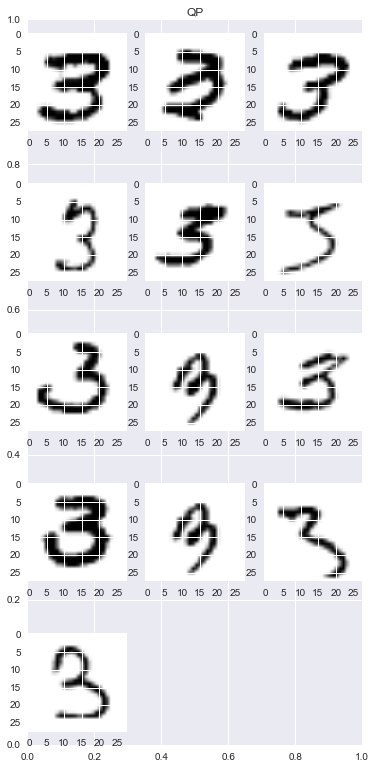

Peg        QP        Peg        QP
200  0.110000  0.110000   8.190520  1.691492
300  0.060000  0.060000   8.784740  2.774450
400  0.043333  0.043333  13.648263  3.981143
500  0.043333  0.043333  18.386949  5.249341

Classifying 4 vs 9 

Classifying with  200  samples
Training Peg took  243  iterations!


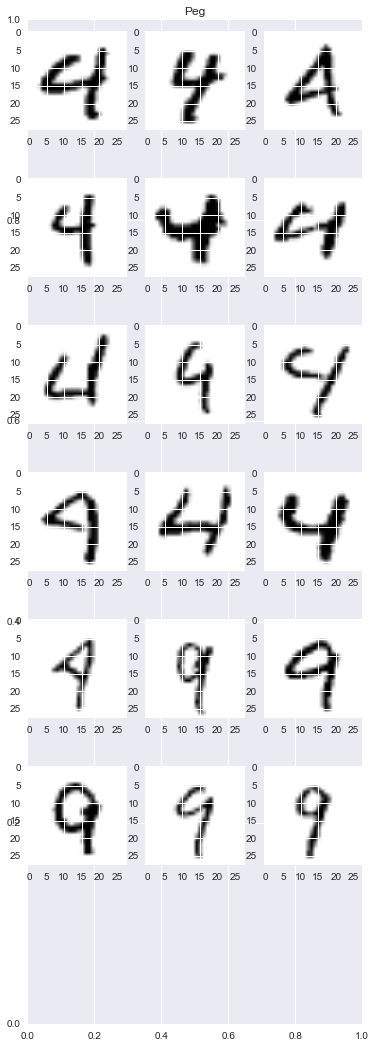

     pcost       dcost       gap    pres   dres
 0: -1.0479e+02 -2.3563e+01  1e+03  4e+01  5e-17
 1: -1.9877e+01 -1.6618e+00  8e+01  2e+00  5e-16
 2: -5.3240e-01 -9.5981e-01  1e+00  1e-02  1e-15
 3: -4.6504e-01 -5.5868e-01  9e-02  3e-15  4e-16
 4: -4.9892e-01 -5.0028e-01  1e-03  7e-16  2e-16
 5: -4.9962e-01 -4.9964e-01  1e-05  7e-16  2e-16
 6: -4.9963e-01 -4.9963e-01  1e-07  2e-15  2e-16
Optimal solution found.


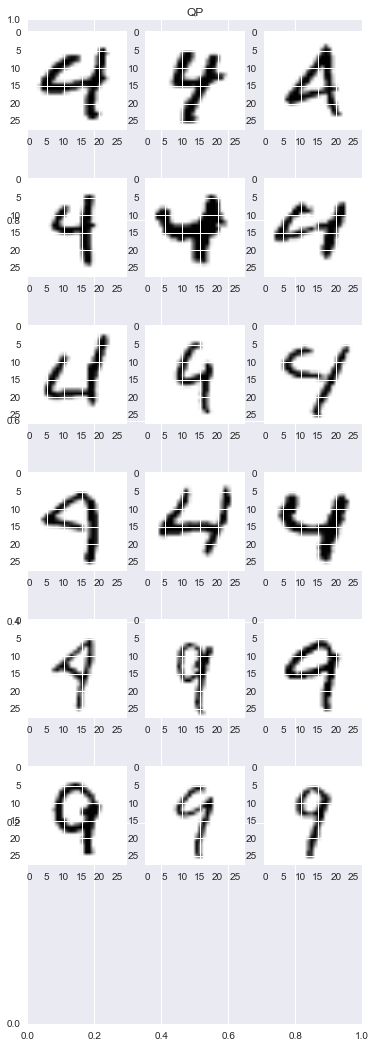


Classifying with  300  samples
Training Peg took  200  iterations!


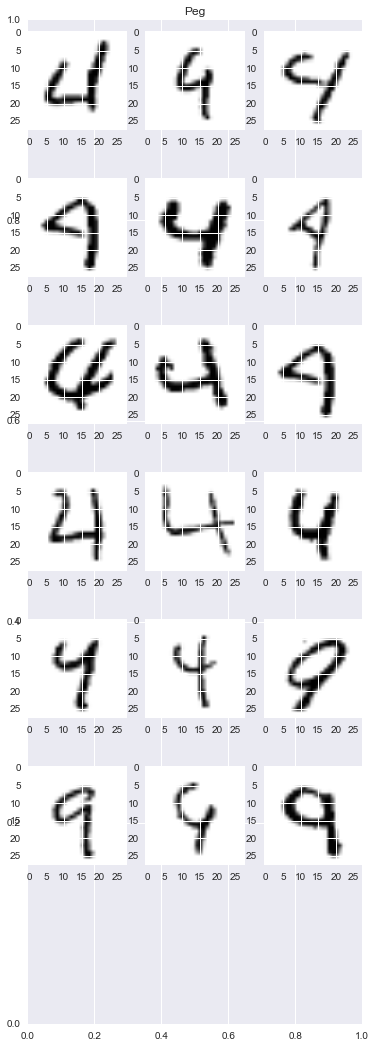

     pcost       dcost       gap    pres   dres
 0: -1.5072e+02 -3.5321e+01  2e+03  5e+01  1e-16
 1: -3.1009e+01 -2.2993e+00  1e+02  3e+00  4e-16
 2: -6.1859e-01 -9.6585e-01  1e+00  2e-02  7e-16
 3: -4.5007e-01 -6.4930e-01  2e-01  4e-16  4e-16
 4: -4.9609e-01 -5.0170e-01  6e-03  1e-15  2e-16
 5: -4.9969e-01 -4.9975e-01  6e-05  1e-15  2e-16
 6: -4.9973e-01 -4.9973e-01  6e-07  2e-15  2e-16
 7: -4.9973e-01 -4.9973e-01  6e-09  5e-16  2e-16
Optimal solution found.


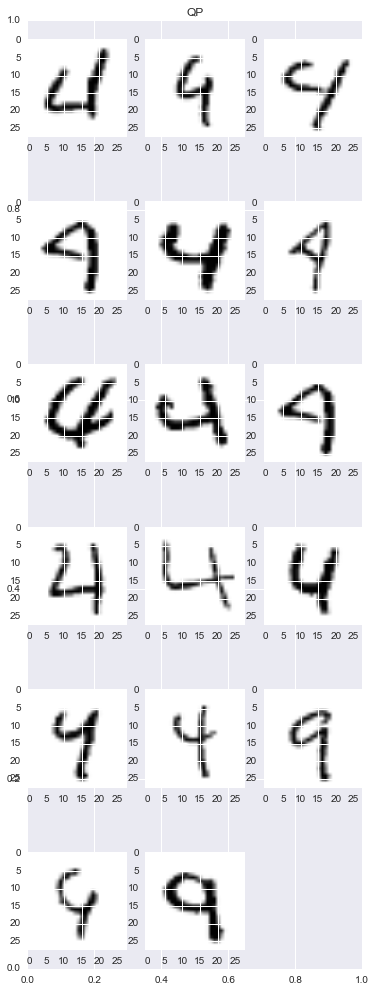


Classifying with  400  samples
Training Peg took  174  iterations!


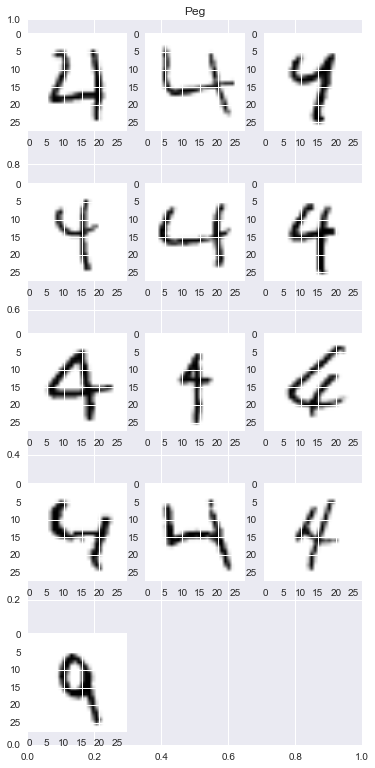

     pcost       dcost       gap    pres   dres
 0: -1.9574e+02 -4.7091e+01  3e+03  5e+01  2e-16
 1: -4.2154e+01 -2.9872e+00  2e+02  4e+00  4e-16
 2: -7.3447e-01 -9.6859e-01  2e+00  3e-02  7e-16
 3: -4.4592e-01 -7.1421e-01  3e-01  2e-15  6e-16
 4: -4.9338e-01 -5.0273e-01  9e-03  3e-15  5e-16
 5: -4.9972e-01 -4.9981e-01  9e-05  1e-15  5e-16
 6: -4.9978e-01 -4.9978e-01  9e-07  6e-16  2e-16
 7: -4.9978e-01 -4.9978e-01  9e-09  4e-15  3e-16
Optimal solution found.


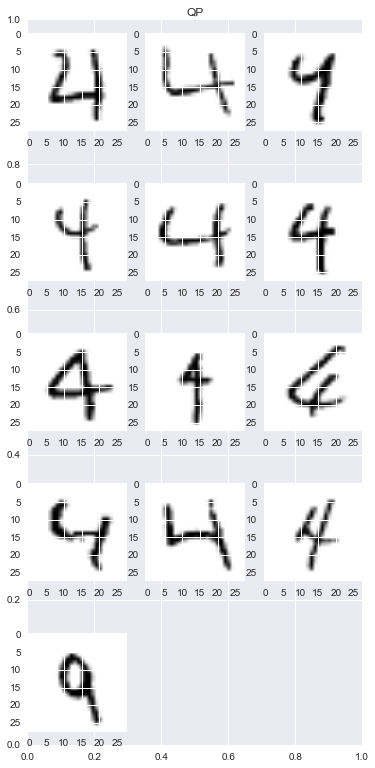


Classifying with  500  samples
Training Peg took  156  iterations!


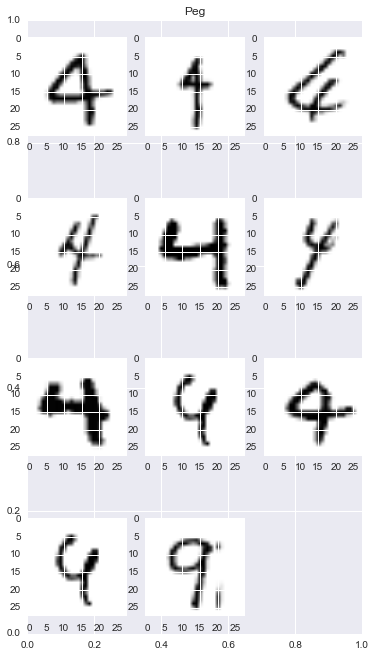

     pcost       dcost       gap    pres   dres
 0: -2.3596e+02 -5.8995e+01  3e+03  6e+01  2e-16
 1: -5.4011e+01 -3.9476e+00  2e+02  4e+00  3e-16
 2: -8.5550e-01 -9.7221e-01  3e+00  4e-02  1e-15
 3: -4.4405e-01 -7.5978e-01  3e-01  6e-16  5e-16
 4: -4.9139e-01 -5.0345e-01  1e-02  3e-15  4e-16
 5: -4.9973e-01 -4.9985e-01  1e-04  1e-15  3e-16
 6: -4.9981e-01 -4.9981e-01  1e-06  3e-15  2e-16
 7: -4.9981e-01 -4.9981e-01  1e-08  1e-15  3e-16
Optimal solution found.


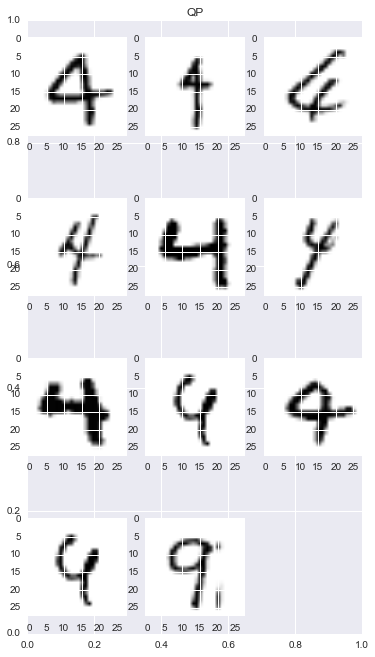

Peg        QP        Peg        QP
200  0.060000  0.060000   5.967061  1.695768
300  0.060000  0.056667   9.301627  2.926683
400  0.043333  0.043333  11.705343  4.024974
500  0.036667  0.036667  18.091244  5.027017

Classifying ['0', '2', '4', '6', '8'] vs ['1', '3', '5', '7', '9'] 

Classifying with  200  samples
Training Peg took  111  iterations!


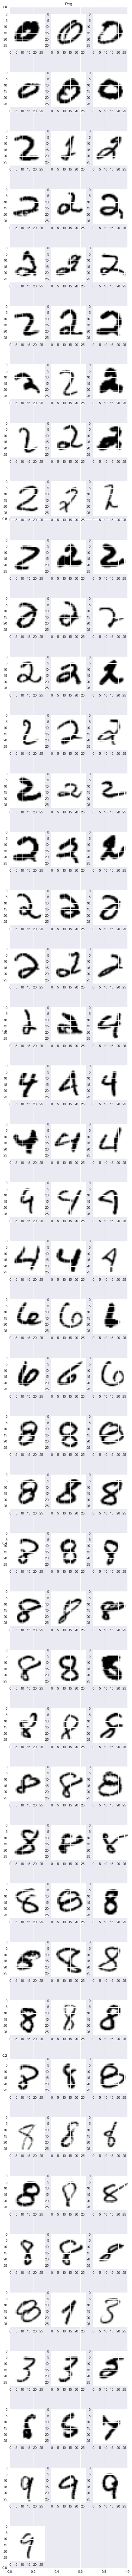

     pcost       dcost       gap    pres   dres
 0: -5.2539e+02 -1.1416e+02  7e+03  8e+01  2e-16
 1: -9.7878e+01 -4.4020e+00  4e+02  6e+00  1e-16
 2: -1.3246e+00 -9.6598e-01  4e+00  5e-02  7e-16
 3: -4.4232e-01 -8.3984e-01  4e-01  2e-14  3e-16
 4: -4.8822e-01 -5.0391e-01  2e-02  8e-15  2e-16
 5: -4.9981e-01 -4.9997e-01  2e-04  4e-15  9e-17
 6: -4.9993e-01 -4.9993e-01  2e-06  4e-15  1e-16
 7: -4.9993e-01 -4.9993e-01  2e-08  9e-15  1e-16
Optimal solution found.


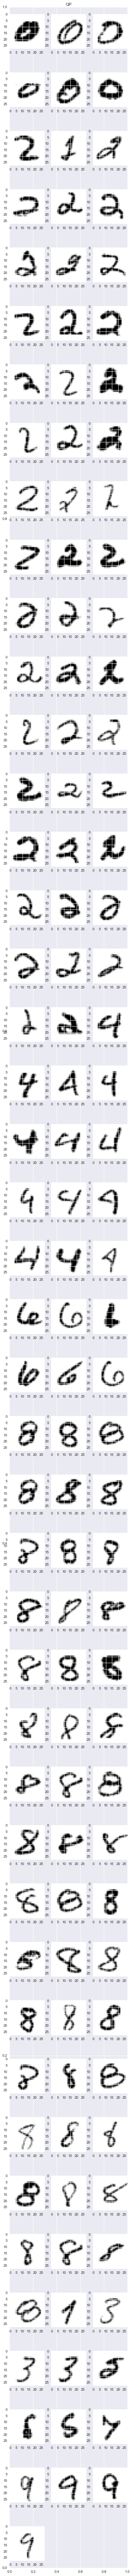


Classifying with  300  samples
Training Peg took  91  iterations!


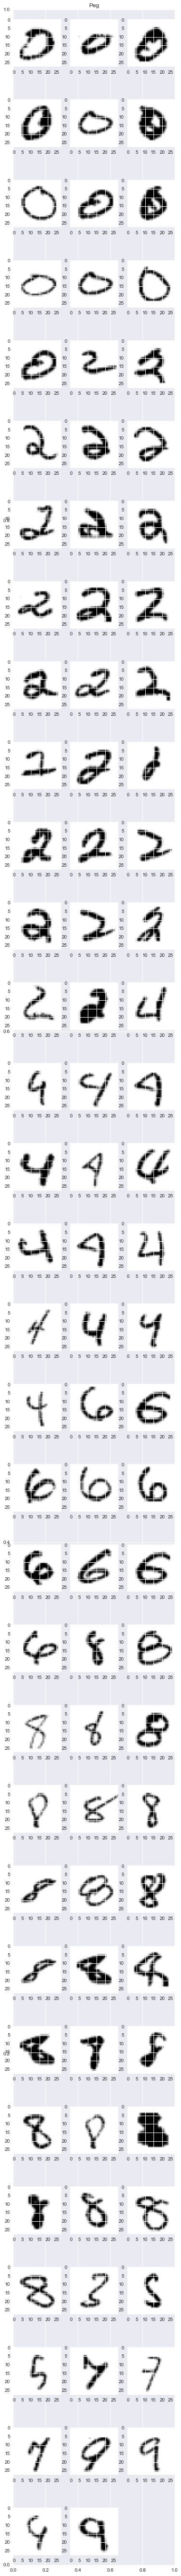

     pcost       dcost       gap    pres   dres
 0: -7.6171e+02 -1.7253e+02  1e+04  1e+02  1e-16
 1: -1.5249e+02 -7.3131e+00  6e+02  7e+00  6e-16
 2: -1.9178e+00 -9.6976e-01  8e+00  8e-02  6e-16
 3: -4.3368e-01 -8.9114e-01  5e-01  1e-14  5e-16
 4: -4.8397e-01 -5.0491e-01  2e-02  2e-15  2e-16
 5: -4.9979e-01 -5.0000e-01  2e-04  7e-15  4e-16
 6: -4.9995e-01 -4.9995e-01  2e-06  1e-14  2e-16
 7: -4.9995e-01 -4.9995e-01  2e-08  1e-14  2e-16
Optimal solution found.


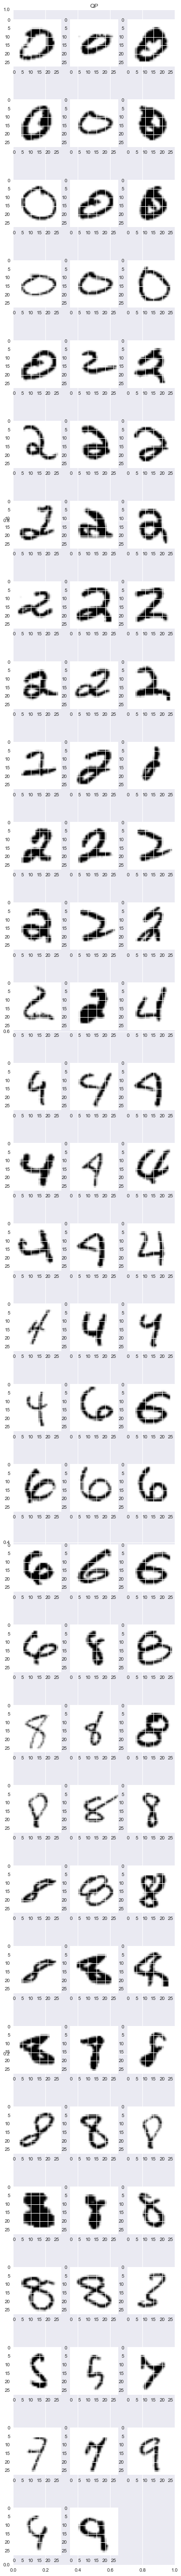


Classifying with  400  samples
Training Peg took  79  iterations!


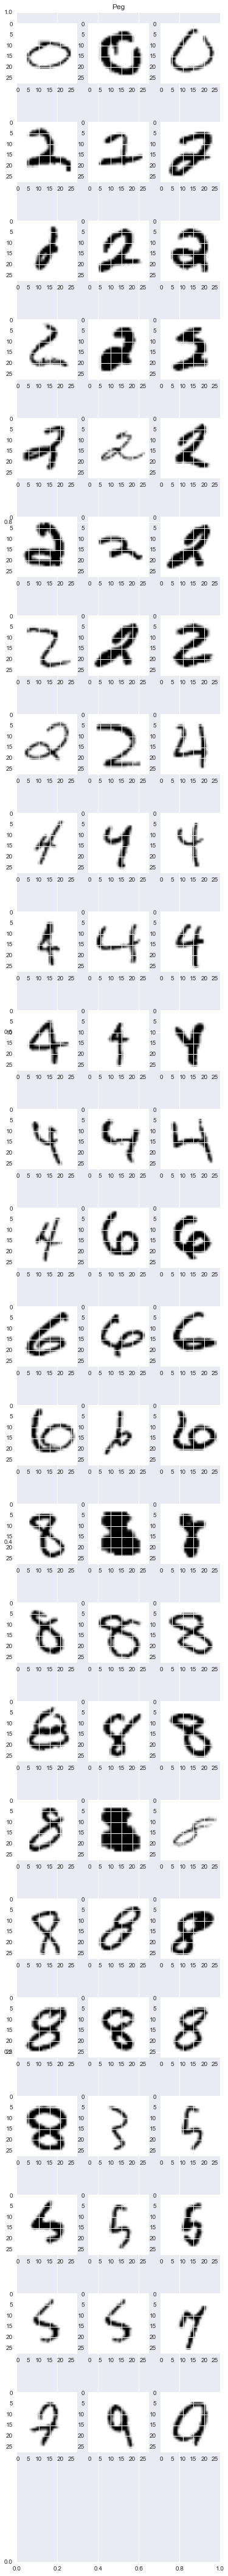

     pcost       dcost       gap    pres   dres
 0: -9.8552e+02 -2.3126e+02  1e+04  1e+02  1e-16
 1: -2.0827e+02 -1.0892e+01  8e+02  8e+00  3e-16
 2: -2.5027e+00 -9.7212e-01  1e+01  9e-02  6e-16
 3: -4.3386e-01 -9.1202e-01  5e-01  1e-14  6e-16
 4: -4.8317e-01 -5.0551e-01  2e-02  2e-15  3e-16
 5: -4.9979e-01 -5.0002e-01  2e-04  2e-14  2e-16
 6: -4.9996e-01 -4.9996e-01  2e-06  9e-17  2e-16
 7: -4.9996e-01 -4.9996e-01  2e-08  1e-14  8e-17
Optimal solution found.


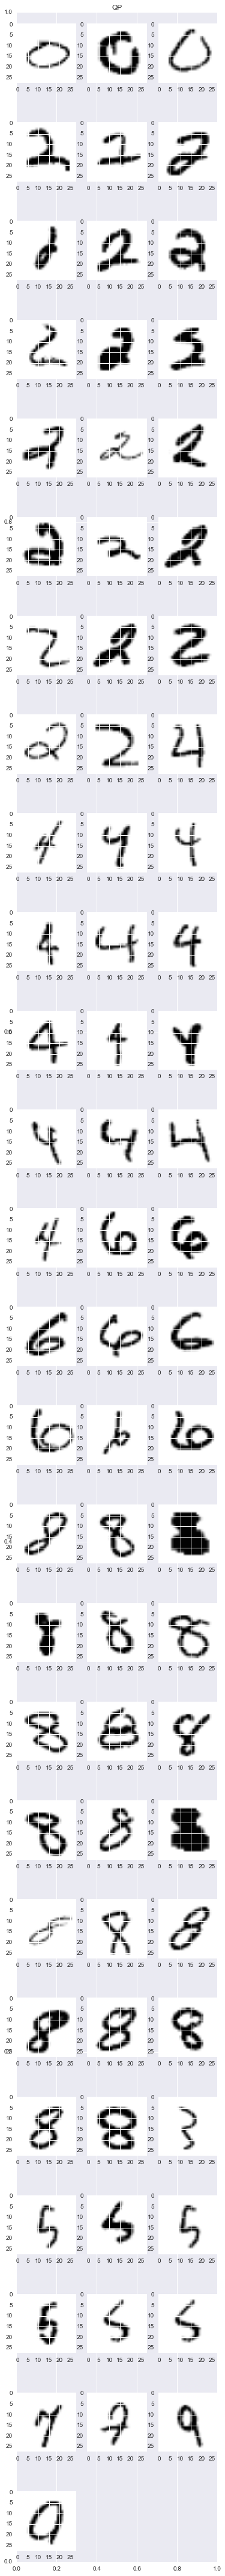


Classifying with  500  samples
Training Peg took  71  iterations!


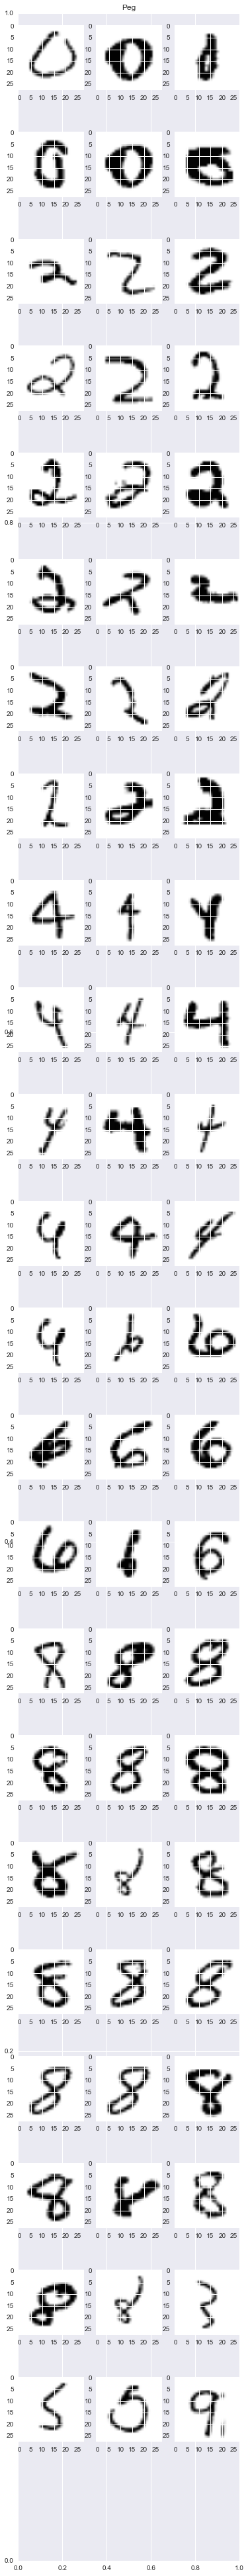

     pcost       dcost       gap    pres   dres
 0: -1.1881e+03 -2.9089e+02  2e+04  1e+02  2e-16
 1: -2.6741e+02 -1.5551e+01  1e+03  9e+00  2e-16
 2: -3.1161e+00 -9.7498e-01  1e+01  1e-01  6e-16
 3: -4.3480e-01 -9.2593e-01  5e-01  3e-14  5e-16
 4: -4.8288e-01 -5.0607e-01  2e-02  2e-14  3e-16
 5: -4.9979e-01 -5.0003e-01  2e-04  1e-14  3e-16
 6: -4.9996e-01 -4.9996e-01  2e-06  2e-14  1e-16
 7: -4.9996e-01 -4.9996e-01  2e-08  2e-14  3e-16
Optimal solution found.


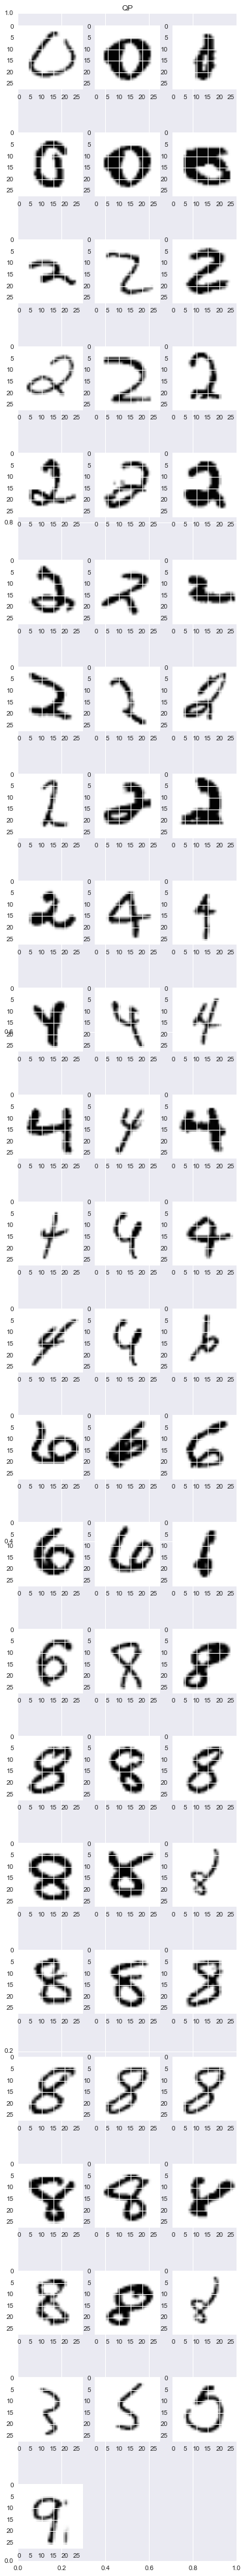

Peg        QP         Peg          QP
200  0.086667  0.086667   89.984650   45.310843
300  0.063333  0.063333  154.091823   82.607972
400  0.050000  0.050667  242.407773  118.578958
500  0.046000  0.046667  370.948161  158.299181

In [32]:
for task in tasks[:1]: 
    print 'Classifying %s vs %s '% (task[0],task[1])
    display(MNIST().classify(task,epoch=1000))        
    

In [178]:
for task in tasks: 
    print 'Classifying %s vs %s '% (task[0],task[1])
    display(MNIST().classify(task,epoch=10))        
    

Classifying 1 vs 7 

Classifying with  200  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.0587e+02 -2.3483e+01  1e+03  4e+01  2e-16
 1: -1.9642e+01 -1.6186e+00  8e+01  2e+00  3e-16
 2: -5.3233e-01 -9.5969e-01  1e+00  1e-02  5e-16
 3: -4.6489e-01 -5.5895e-01  9e-02  4e-16  3e-16
 4: -4.9893e-01 -5.0029e-01  1e-03  2e-15  2e-16
 5: -4.9963e-01 -4.9965e-01  1e-05  2e-15  3e-16
 6: -4.9964e-01 -4.9964e-01  1e-07  1e-15  1e-16
Optimal solution found.

Classifying with  300  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.5419e+02 -3.5147e+01  2e+03  5e+01  8e-17
 1: -3.0194e+01 -2.1178e+00  1e+02  3e+00  6e-16
 2: -6.2219e-01 -9.6415e-01  1e+00  2e-02  9e-16
 3: -4.5769e-01 -6.3333e-01  2e-01  1e-15  3e-16
 4: -4.9723e-01 -5.0115e-01  4e-03  9e-16  2e-16
 5: -4.9972e-01 -4.9976e-01  4e-05  5e-16  4e-16
 6: -4.9974e-01 -4.9974e-01  4e-07  1e-15  3e-16
Optimal solution found.

Classifying wit

Peg    QP        Peg        QP
200  0.01  0.01   3.587008  2.168649
300  0.01  0.01   5.831230  2.846863
400  0.01  0.01   9.953164  4.133302
500  0.01  0.01  17.248879  5.004246

Classifying 3 vs 5 

Classifying with  200  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.0492e+02 -2.3534e+01  1e+03  4e+01  1e-16
 1: -1.9832e+01 -1.6631e+00  8e+01  2e+00  5e-16
 2: -5.3216e-01 -9.5965e-01  1e+00  1e-02  8e-16
 3: -4.6500e-01 -5.5859e-01  9e-02  5e-16  4e-16
 4: -4.9892e-01 -5.0028e-01  1e-03  4e-16  2e-16
 5: -4.9962e-01 -4.9964e-01  1e-05  1e-15  8e-17
 6: -4.9963e-01 -4.9963e-01  1e-07  4e-16  3e-16
Optimal solution found.

Classifying with  300  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.5208e+02 -3.5196e+01  2e+03  5e+01  1e-16
 1: -3.0557e+01 -2.2432e+00  1e+02  3e+00  3e-16
 2: -6.2246e-01 -9.6494e-01  1e+00  2e-02  8e-16
 3: -4.5761e-01 -6.3380e-01  2e-01  1e-15  4e-16
 4: -4.9721e-01 -5.0114e-01  4e-03  2e-15  2e-16
 5: -4.9971e-01 -4.9975e-01  4e-05  1e-15  1e-16
 6: -4.9973e-01 -4.9973e-01  4e-07  1e-15  2e-16
Optimal solution found.

Classifying wit

Peg        QP        Peg        QP
200  0.110000  0.110000   2.822104  1.602493
300  0.060000  0.060000   5.316588  2.622153
400  0.043333  0.043333   8.929363  4.542445
500  0.043333  0.043333  13.229105  5.075523

Classifying 4 vs 9 

Classifying with  200  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.0479e+02 -2.3563e+01  1e+03  4e+01  5e-17
 1: -1.9877e+01 -1.6618e+00  8e+01  2e+00  5e-16
 2: -5.3240e-01 -9.5981e-01  1e+00  1e-02  1e-15
 3: -4.6504e-01 -5.5868e-01  9e-02  3e-15  4e-16
 4: -4.9892e-01 -5.0028e-01  1e-03  7e-16  2e-16
 5: -4.9962e-01 -4.9964e-01  1e-05  7e-16  2e-16
 6: -4.9963e-01 -4.9963e-01  1e-07  2e-15  2e-16
Optimal solution found.

Classifying with  300  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -1.5072e+02 -3.5321e+01  2e+03  5e+01  1e-16
 1: -3.1009e+01 -2.2993e+00  1e+02  3e+00  4e-16
 2: -6.1859e-01 -9.6585e-01  1e+00  2e-02  7e-16
 3: -4.5007e-01 -6.4930e-01  2e-01  4e-16  4e-16
 4: -4.9609e-01 -5.0170e-01  6e-03  1e-15  2e-16
 5: -4.9969e-01 -4.9975e-01  6e-05  1e-15  2e-16
 6: -4.9973e-01 -4.9973e-01  6e-07  2e-15  2e-16
 7: -4.9973e-01 -4.9973e-01  6e-09  5e-1

Peg        QP        Peg        QP
200  0.063333  0.060000   2.803911  1.663478
300  0.060000  0.056667   5.500363  2.639623
400  0.043333  0.043333   9.598415  3.908273
500  0.036667  0.036667  12.232759  5.903003

Classifying ['0', '2', '4', '6', '8'] vs ['1', '3', '5', '7', '9'] 

Classifying with  200  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -5.2539e+02 -1.1416e+02  7e+03  8e+01  2e-16
 1: -9.7878e+01 -4.4020e+00  4e+02  6e+00  1e-16
 2: -1.3246e+00 -9.6598e-01  4e+00  5e-02  7e-16
 3: -4.4232e-01 -8.3984e-01  4e-01  2e-14  3e-16
 4: -4.8822e-01 -5.0391e-01  2e-02  8e-15  2e-16
 5: -4.9981e-01 -4.9997e-01  2e-04  4e-15  9e-17
 6: -4.9993e-01 -4.9993e-01  2e-06  4e-15  1e-16
 7: -4.9993e-01 -4.9993e-01  2e-08  9e-15  1e-16
Optimal solution found.

Classifying with  300  samples
Training Peg took  10  iterations!
     pcost       dcost       gap    pres   dres
 0: -7.6171e+02 -1.7253e+02  1e+04  1e+02  1e-16
 1: -1.5249e+02 -7.3131e+00  6e+02  7e+00  6e-16
 2: -1.9178e+00 -9.6976e-01  8e+00  8e-02  6e-16
 3: -4.3368e-01 -8.9114e-01  5e-01  1e-14  5e-16
 4: -4.8397e-01 -5.0491e-01  2e-02  2e-15  2e-16
 5: -4.9979e-01 -5.0000e-01  2e-04  7e-15

Peg        QP         Peg          QP
200  0.086667  0.086667   70.350677   46.831557
300  0.063333  0.063333  137.032323   77.685739
400  0.050000  0.050667  217.271902  111.747256
500  0.046000  0.046667  327.217935  172.945021